Consider the system 
$$\left\{\begin{array}{l}
S'=-u\beta SI\\
I'=u\beta SI-\nu I\\
R'=\nu I\\
S(t_0)=1-I_0,I(t_0)=\frac{I_0}{N},R(t_0)=0
\end{array}\right.$$
where $S_0+I_0+R_0=1$.

The goal is to solve the optimal control proplem
$$\inf\limits_{u\in\mathcal{U}}J(u)$$
where 
$$
J(u)=S(T)+I(T)-\frac{\nu}{\beta}\ln(S(T))=S_0+I_0-\frac{\nu}{\beta}\ln(S_0)+\int_0^T\nu I(u-1),
$$
 and
$$\mathcal{U}=\{u\in L^{\infty}(0,T):\alpha\leqslant u\leqslant 1\}$$

One has 
$$
DJ(u)\cdot h=\int_0^T[\nu -\beta S(P_I-P_S)]Ih,
$$
where
\begin{equation*}
\left\{\begin{array}{l}
 -\frac{d }{d t}\begin{pmatrix} P_S \\ P_I \end{pmatrix} = \begin{pmatrix}-u\beta I & u\beta I\\ -u\beta S & u\beta S-\nu \end{pmatrix}\begin{pmatrix}P_S \\ P_I \end{pmatrix}+\begin{pmatrix} 0\\ -(u-1)I \end{pmatrix},\\
P_S(T)=0, \ P_I(T)=0
\end{array}\right.
\end{equation*}


In [1]:
from __future__ import division
from IPython.display import display, Math, Markdown
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parameters of the model
beta=0.29
nu=0.1
t0=0
alpha_conf = 0.231

# state initialization 
N=6.7e7
I0=1000/N
S0=1-I0
R0=0
init=np.array([S0, I0,R0,0.0]) 



In [3]:

def f(u,y):
	dy = np.array([-u*beta*y[0]*y[1],u*beta*y[0]*y[1]-nu*y[1],nu*y[1],nu*y[1]*(u-1.0)])
	return dy

def RK4_state(u,init):
	# solved in the time interval [a,b] 
	# initial conditions = vector alpha
	# number of subdivisions  in the interval [a,b] = N
	w = np.zeros((NT,4))
	w[0,:] = init    #initial conditions
	for i in range(NT-1):
		k1 = h*f(u[i], w[i,:])
		k2 = h*f(0.5*(u[i]+u[i+1]), w[i,:]+0.5*k1)
		k3 = h*f(0.5*(u[i]+u[i+1]), w[i,:]+0.5*k2) 
		k4 = h*f(u[i+1], w[i,:]+k3)
		w[i+1,:] = w[i,:] + (k1 + 2*k2 + 2*k3 + k4)/6
	return w

def f_dual(i,u_i,ystate,p_i):
	a11=-beta*u_i*ystate[i,1]
	a12=-beta*u_i*ystate[i,0]
	a21=beta*u_i*ystate[i,1]
	a22=beta*u_i*ystate[i,0]-nu
	A=np.matrix([[a11, a12],[a21 ,a22]])
	return np.transpose(np.transpose(A)*np.transpose(np.matrix(p_i)))-np.matrix([0,nu*(u_i-1.0)])

def RK4_adj(u,ystate):
	# solved in the time interval [a,b] 
	# initial conditions = vector alpha
	# number of subdivisions  in the interval [a,b] = N
	pT = np.zeros((NT,2))
	pT[-1,:] = np.array([0.0,0.0])
	for i in list(reversed(range(1,NT))):
		k1 = h*f_dual(i,u[i],ystate,pT[i,:])
		k2 = h*f_dual(i,0.5*(u[i]+u[i-1]),ystate,pT[i,:]+0.5*k1)
		k3 = h*f_dual(i,0.5*(u[i]+u[i-1]),ystate,pT[i,:]+0.5*k2) 
		k4 = h*f_dual(i,u[i-1],ystate,pT[i,:]+k3)
		pT[i-1,:] = pT[i,:] + (k1 + 2*k2 + 2*k3 + k4)/6
	return pT

def J(y):
    return S0+I0-(nu/beta)*np.log(S0)+y[-1,-1]

def DJ(y,p):
    return y[:,1]*(nu-beta*y[:,0]*(p[:,1]-p[:,0]))


def Dicho_S_inf(val):
    S_inf_min = 0.0 # borne gauche de l'intervalle initial
    S_inf_max = nu/beta # borne gauche de l'intervalle initial b>a
    val_max = S_inf_min-(nu/beta)*np.log(S_inf_min)
    val_min = S_inf_max-(nu/beta)*np.log(S_inf_max)
    while S_inf_max-S_inf_min > 1e-5:
            S_inf=0.5*(S_inf_max+S_inf_min)
            val_test=S_inf-(nu/beta)*np.log(S_inf)
            if val_test > val:
                    S_inf_min=S_inf
            else:
                    S_inf_max=S_inf
    return 0.5*(S_inf_max+S_inf_min);

def optimSIR(uinit,init,info):
	u=uinit
	yval=RK4_state(u,init)
	pval=RK4_adj(u,yval)
	Jnew=J(yval)
	Jval = [Jnew]
	Delta2=1
	#norm_grad = 1
	i=0
	rho=1000 # pas dans la methode de gradient
	while (abs(Delta2)>1e-10 and i<ITER):        
		rho=100*rho#np.minimum(100*rho,1000.0)
		yval=RK4_state(u,init)
		pval=RK4_adj(u,yval)
		Delta=1
		k1=0
		while (Delta>0) and (k1<100): # recherche du pas
			rho=rho/1.2
			utest=u-rho*DJ(yval,pval)
			utest=np.maximum(alpha,np.minimum(utest,1))
			yval_test=RK4_state(utest,init)
			Jnew=J(yval_test)
			Delta=Jnew-Jval[-1]
			k1=k1+1
		k2=0
		utest2=utest
		Jnew2=Jnew
		Delta=-1
		while (Delta<0) and (k2<100): # recherche du pas
			rho=rho/1.2
			Jnew1=Jnew2     
			utest1=utest2 
			utest2=u-rho*DJ(yval,pval)
			utest2=np.maximum(alpha,np.minimum(utest2,1))
			yval_test=RK4_state(utest2,init)
			Jnew2=J(yval_test)
			Delta=Jnew2-Jnew1
			k2=k2+1
		Delta1=Jnew-Jval[-1]
		Delta2=Jnew1-Jval[-1]
		norm_grad = np.linalg.norm(DJ(yval,pval))
		print('norm grad',norm_grad)
		if info == True:
			print('i=',i,'and J=',Jnew,'rho=',rho)  
			print('k1=',k1,'k2=',k2,'delta2',Delta2)      
		u=np.copy(utest1)
		Jval.append(Jnew1)
		i=i+1
	if (i==iter):
		print('maximal number of iterations reached')
	print('end of computations')
	return u, i, Jnew, Jval, yval




def optimSIR_dic_finite_dim(T,init):
	T0_ind_min = 0 # borne gauche de l'intervalle initial
	T0_ind_max = NT-1 # borne gauche de l'intervalle initial b>a
	while T0_ind_max-T0_ind_min>2:
		T0_ind_test1=int(T0_ind_min+1/3*(T0_ind_max-T0_ind_min))
		T0_ind_test2=int(T0_ind_min+2/3*(T0_ind_max-T0_ind_min))
		u1=np.ones(int(NT))
		for i in range(T0_ind_test1,int(NT)):
			u1[i]=alpha
		yval1=RK4_state(u1,init)
		J1 = J(yval1)
		u2=np.ones(int(NT))
		for i in range(T0_ind_test2,int(NT)):
			u2[i]=alpha
		yval2=RK4_state(u2,init)
		J2 = J(yval2)    
		if J1 < J2:
			T0_ind_max=T0_ind_test2
		else:
			T0_ind_min=T0_ind_test1
	return u1, J1, yval1, tval[T0_ind_test1]


def exact_value_T0(T,alpha):
    tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
    h = (T-t0)/(NT-1)        #the time step
    Sherd = nu/beta
    T0_ind_min = 0 # borne gauche de l'intervalle initial
    T0_ind_max = int(NT-1) # borne gauche de l'intervalle initial b>a
    while T0_ind_max - T0_ind_min>1:
        T0_ind=int(0.5*(T0_ind_min+T0_ind_max))
        u=np.ones(int(NT))
        for ind in range(T0_ind,NT):
            u[ind]=alpha
        yval = RK4_state(u,init)
        if alpha == 0:
            phi = yval[T0_ind,0]*(1-np.exp(nu*(tval[T0_ind]-T))) - Sherd
        else:
            #phi=(1.0-alpha)*yval[-1,1]*(1.0/yval[T0_ind,1]+nu*h*sum(1.0/yval[i,1] for i in range(T0_ind,NT)))-1.0
            phi=yval[-1,1]*(1.0-alpha)*beta*h*sum(yval[i,0]/yval[i,1] for i in range(T0_ind,NT))-1.0
        if phi <=0:
            T0_ind_max=T0_ind
        else:
            T0_ind_min=T0_ind
    T0 = tval[T0_ind]
    S_inf = Dicho_S_inf(J(yval))
    return S_inf, max(T0,0.0), u, J(yval), yval, tval

# functions to plot and save datas

def write_to_file(f,A,B):
    f.write('\n')
    for i in range(len(A)):
        f.write('(')
        f.write(str(A[i]))
        f.write(',')
        f.write(str(B[i]))
        f.write(')')
        f.write('\n')
    f.write('\n')
    f.write('\n')
    return;

def plot_save_example(yval,u,tval,text):
    # Plot
    plt.figure(1)
    plt.plot(tval,yval[:,0],'r-',linewidth=2,label=r'$S$')
    plt.plot(tval,yval[:,1],'g-',linewidth=2,label=r'$I$')
    plt.plot(tval,yval[:,2],'b-',linewidth=2,label=r'$R$')
    plt.plot(tval,(1.0/2.9)*np.ones(len(tval)),'k--',linewidth=2,label=r'$S_{herd}$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.savefig("fig1_simu_covid{2}_T_{0}_alpha_{1}_S.png".format(T,alpha,text))
    plt.figure(2)
    plt.plot(tval,u,'-',linewidth=2,label=r'$u$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.axis([0, max(tval), 0, 1.05*max(u)])
    plt.savefig("fig1_simu_covid{2}_T_{0}_alpha_{1}_u.png".format(T,alpha,text))
    plt.show()


    # Save the values for tikz
    File = open('fig1_simu_covid{2}_T_{0}_alpha_{1}.txt'.format(T,alpha,text),'w')
    File.write('\\addplot[color=red] coordinates { ')
    write_to_file(File,tval,yval[:,0])
    File.write(' };\n')
    File.write('\\addplot[color=black!60!green] coordinates { ')
    write_to_file(File,tval,yval[:,1])
    File.write(' };\n')
    File.write('\\addplot[color=blue] coordinates { ')
    write_to_file(File,tval,yval[:,2])
    File.write(' };\n')
    File.write('\\addplot[color=black] coordinates {')
    write_to_file(File,tval,u)
    File.write(' };\n')
    File.close()
    return ;


def plot_save_opt_sol(Jval1,yval1,u1,yval2,u2,tval,fig):
    # Plot
    plt.figure(1)
    plt.plot(Jval1,'b-',linewidth=2,label=r'$J(u)$')
    plt.legend(loc='best')
    plt.xlabel('iterations')
    plt.axis([0, len(Jval1)-1, min(Jval1), max(Jval1)])
    plt.savefig("fig{2}_simu_covid_infinite_dim_T_{0}_alpha_{1}_J.png".format(T,alpha,fig))
    plt.figure(2)
    plt.plot(tval,yval1[:,0],'r-',linewidth=2,label=r'$S(u)$')
    plt.plot(tval,yval1[:,1],'g-',linewidth=2,label=r'$I(u)$')
    plt.plot(tval,yval1[:,2],'b-',linewidth=2,label=r'$R(u)$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.savefig("fig{2}_simu_covid_infinite_dim_T_{0}_alpha_{1}_S.png".format(T,alpha,fig))
    plt.figure(3)
    plt.plot(tval,u1,'-',linewidth=2,label=r'$u$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.axis([0, max(tval), 0, 1.05*max(u1)])
    plt.savefig("fig{2}_simu_covid_infinite_dim_T_{0}_alpha_{1}_u.png".format(T,alpha,fig))
    
    plt.figure(4)
    plt.plot(tval,yval2[:,0],'r-',linewidth=2,label=r'$S(T_0)$')
    plt.plot(tval,yval2[:,1],'g-',linewidth=2,label=r'$I(T_0)$')
    plt.plot(tval,yval2[:,2],'b-',linewidth=2,label=r'$R(T_0)$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.savefig("fig{2}_simu_covid_finite_dim_T_{0}_alpha_{1}_S.png".format(T,alpha,fig))
    plt.figure(5)
    plt.plot(tval,u2,'-',linewidth=2,label=r'$u(T_0)$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.axis([0, max(tval), 0, 1.05*max(u2)])
    plt.savefig("fig{2}_simu_covid_finite_dim_T_{0}_alpha_{1}_u.png".format(T,alpha,fig))
    plt.show()


    # Save the values for tikz
    File = open('fig{2}_simu_covid_T_{0}_alpha_{1}_sol.txt'.format(T,alpha,fig),'w')
    File.write('\\addplot[color=red,opacity = 0.25,line width=1mm] coordinates { ')
    write_to_file(File,tval,yval1[:,0])
    File.write(' };\n')
    File.write('\\addplot[color=red] coordinates { ')
    write_to_file(File,tval,yval2[:,0])
    File.write(' };\n')
    File.write('\\addplot[color=black!60!green,opacity = 0.25,line width=1mm] coordinates { ')
    write_to_file(File,tval,yval1[:,1])
    File.write(' };\n')
    File.write('\\addplot[color=black!60!green] coordinates { ')
    write_to_file(File,tval,yval2[:,1])
    File.write(' };\n')
    File.write('\\addplot[color=blue,opacity = 0.25,line width=1mm] coordinates { ')
    write_to_file(File,tval,yval1[:,2])
    File.write(' };\n')
    File.write('\\addplot[color=blue] coordinates { ')
    write_to_file(File,tval,yval2[:,2])
    File.write(' };\n')
    File.close()
    File = open('fig{2}_simu_covid_T_{0}_alpha_{1}_control.txt'.format(T,alpha,fig),'w')
    File.write('\\addplot[color=black,opacity = 0.25,line width=1mm] coordinates {')
    write_to_file(File,tval,u1)
    File.write(' };\n')
    File.write('\\addplot[color=black] coordinates {')
    write_to_file(File,tval,u2)
    File.write(' };\n')
    File.close()
    return ;

/home/duprez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


('$S_{inf}:', 0.06677824875404095)
('$S_{herd}:', 0.3448275862068966)
('$(S_{herd}-S_{inf})/(1-S_{inf}):', 0.2979456244795276)


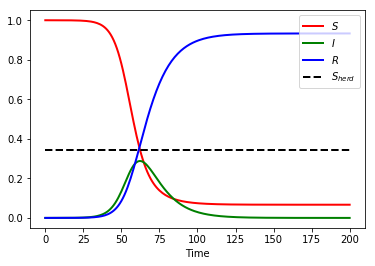

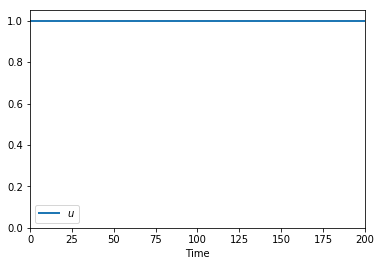

('Time of switch:', 62.2)


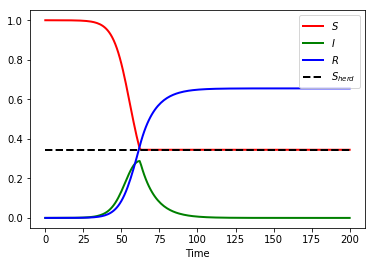

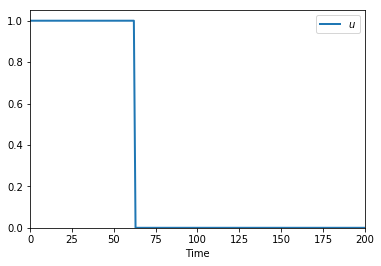

In [4]:
# examples of controls (figure 1)
T=200.0
alpha=0.0
# discretisation parameters
NT=int(10001) # number of time step
ITER = 5e4 # number of step in optimisation
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)        #the time step



# Conpute the first solution
u=np.ones(int(NT))
yval=RK4_state(u,init)
ind_max_I = np.argmax(yval[:,1])
tval=tval[::50]
yval=yval[::50,:]
u=u[::50]

Sinf = Dicho_S_inf(J(yval))
print("$S_{inf}:",Sinf)
Sherd = nu/beta
print("$S_{herd}:",Sherd)
print("$(S_{herd}-S_{inf})/(1-S_{inf}):",(Sherd-Sinf)/(1.0-Sinf))

# plot and save solution and control 1
plot_save_example(yval,u,tval,'_example1')

# compute the second solution
tval=np.linspace(t0,T,NT)
u=np.ones(int(NT))
for i in range(int(ind_max_I+1),int(NT)):
    u[i]=0.0
yval=RK4_state(u,init)
print('Time of switch:',tval[ind_max_I])
tval=tval[::50]
yval=yval[::50,:]
u=u[::50]


# plot and save solution and control 2
plot_save_example(yval,u,tval,'_example2')

('norm grad', 0.9365656588536552)
('i=', 0, 'and J=', 0.9999593575942789, 'rho=', 15.823413952872837)
('k1=', 1, 'k2=', 47, 'delta2', -0.18616579464189686)
('norm grad', 0.7835701051793977)
('i=', 1, 'and J=', 0.7255987049986359, 'rho=', 102.70261436495491)
('k1=', 1, 'k2=', 14, 'delta2', -0.09033607884591177)
('norm grad', 0.3472619901639989)
('i=', 2, 'and J=', 0.7218050958682789, 'rho=', 2.3401526128400825)
('k1=', 42, 'k2=', 4, 'delta2', -0.003425349195015137)
('norm grad', 0.037521949596226366)
('i=', 3, 'and J=', 0.72005297414375, 'rho=', 26.246368874162023)
('k1=', 7, 'k2=', 5, 'delta2', -0.00016336282111695244)
('norm grad', 0.07438751414318154)
('i=', 4, 'and J=', 0.7198463477269147, 'rho=', 2.57147246568511)
('k1=', 34, 'k2=', 4, 'delta2', -0.0001519922612499558)
('norm grad', 0.036815597035385436)
('i=', 5, 'and J=', 0.7197386600587312, 'rho=', 16.690263288309485)
('k1=', 11, 'k2=', 4, 'delta2', -8.972425313147347e-05)
('norm grad', 0.06236540743831456)
('i=', 6, 'and J=', 0

('norm grad', 0.03355176782394491)
('i=', 3, 'and J=', 0.7190290490058812, 'rho=', 45.353725414551974)
('k1=', 6, 'k2=', 4, 'delta2', -0.00017729379833064662)
('norm grad', 0.06417994126732283)
('i=', 4, 'and J=', 0.7189107167516501, 'rho=', 170.35329474357977)
('k1=', 12, 'k2=', 6, 'delta2', -8.861645889512992e-05)
('norm grad', 0.031721884871128696)
('i=', 5, 'and J=', 0.7188344181211666, 'rho=', 13.908552740257905)
('k1=', 35, 'k2=', 4, 'delta2', -4.2215090364727814e-05)
('norm grad', 0.0480718867147679)
('i=', 6, 'and J=', 0.7187893500667193, 'rho=', 187.19240978912623)
('k1=', 5, 'k2=', 6, 'delta2', -0.00010734178475102496)
('norm grad', 0.07469898034373848)
('i=', 7, 'and J=', 0.7186919076172446, 'rho=', 54.76314251382261)
('k1=', 27, 'k2=', 5, 'delta2', -2.8564090153948563e-05)
('norm grad', 0.04801417238705375)
('i=', 8, 'and J=', 0.7186604589203196, 'rho=', 142.84447284573443)
('k1=', 15, 'k2=', 5, 'delta2', -2.6920840290656223e-05)
('norm grad', 0.07243827798844521)
('i=', 9,

('norm grad', 0.05316096997397753)
('i=', 55, 'and J=', 0.7184593647747988, 'rho=', 9725.076834652644)
('k1=', 23, 'k2=', 4, 'delta2', -9.727730843067661e-10)
('norm grad', 0.0530047331947323)
('i=', 56, 'and J=', 0.7184593640580493, 'rho=', 14679.943434392462)
('k1=', 12, 'k2=', 11, 'delta2', -9.968268432913874e-10)
('norm grad', 0.05316573347266142)
('i=', 57, 'and J=', 0.7184593631960865, 'rho=', 8905.319240636754)
('k1=', 23, 'k2=', 5, 'delta2', -9.892046071158234e-10)
('norm grad', 0.05301511549089901)
('i=', 58, 'and J=', 0.7184593619468507, 'rho=', 57800.3944339634)
('k1=', 11, 'k2=', 4, 'delta2', -1.0724731103195495e-09)
('norm grad', 0.05307601900355032)
('i=', 59, 'and J=', 0.7184593612426763, 'rho=', 16909.506327249426)
('k1=', 28, 'k2=', 4, 'delta2', -2.376765451117535e-12)
end of computations
('norm grad', 4.487587653360454e-05)
('i=', 0, 'and J=', 0.9999859560972275, 'rho=', 69444.44444444445)
('k1=', 1, 'k2=', 1, 'delta2', -4.265926048629964e-06)
('norm grad', 7.19537635

('norm grad', 0.05277776092268611)
('i=', 47, 'and J=', 0.7184618488401758, 'rho=', 5558.543448793654)
('k1=', 2, 'k2=', 8, 'delta2', -7.932902239549122e-07)
('norm grad', 0.0567953339568783)
('i=', 48, 'and J=', 0.7184608994152746, 'rho=', 453.82917209163844)
('k1=', 35, 'k2=', 4, 'delta2', -4.95102429165506e-07)
('norm grad', 0.053029185440869334)
('i=', 49, 'and J=', 0.7184596181885915, 'rho=', 31515.91472858601)
('k1=', 1, 'k2=', 1, 'delta2', -9.839035786107786e-07)
('norm grad', 0.05458042433749293)
('i=', 50, 'and J=', 0.7184596159516601, 'rho=', 1034.0822669609604)
('k1=', 39, 'k2=', 5, 'delta2', -7.812550106844895e-08)
('norm grad', 0.053191568751074766)
('i=', 51, 'and J=', 0.7184595387402177, 'rho=', 13917.504940131921)
('k1=', 4, 'k2=', 7, 'delta2', -6.452339962326192e-08)
('norm grad', 0.05244382575722883)
('i=', 52, 'and J=', 0.7184594744431705, 'rho=', 1963.5254125738138)
('k1=', 31, 'k2=', 5, 'delta2', -1.9027718733966026e-08)
('norm grad', 0.05311101921735226)
('i=', 53

/home/duprez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


('number of iterations in the optimisation of u:', 60)
('J(u):', 0.7184593612426763)
('J(T0):', 0.7184594534472071)
('T0:', 61.940000000000005)
('S_inf', 0.28217973380253236)


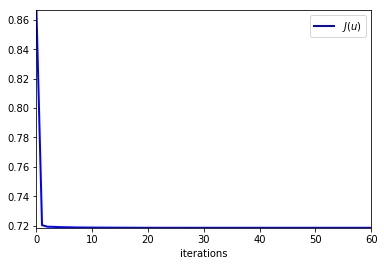

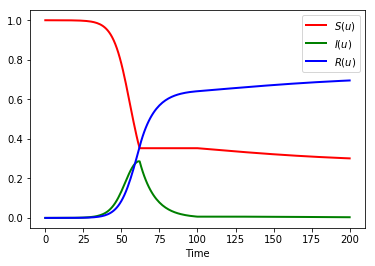

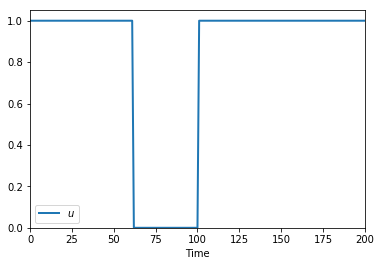

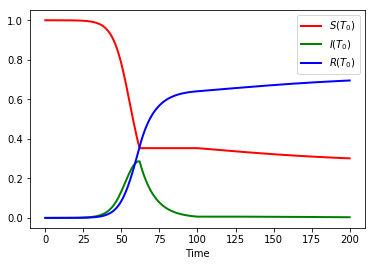

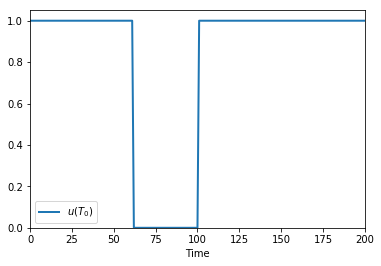

In [5]:
# minimisation with respect to u and T0 for alpha = 0 (figure 3)

# parameters
T=100.0
alpha  = 0.0
NT=int(5001) # number of time step
ITER = 5e4 # number of step in optimisation
T_end = 200.0
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
tval_end = np.linspace(t0,T_end,2*NT-1)#np.concatenate((tval,np.linspace(T,T_end,NT)),axis=0)
h = (T-t0)/(NT-1)        #the time step

# optimisation of u
u=np.ones(int(NT))
u1, i1, Jnew1, Jval1, yval1=optimSIR(u,init,True)
u_test=np.ones(int(NT))
for ind in range(int(NT/2),NT):
    u_test[ind] = alpha
u_test, i_test, Jnew_test, Jval_test, yval_test=optimSIR(u_test,init,True)
if Jval_test<Jval1:
    u1, i1, Jnew1, Jval1, yval1 = u_test, i_test, Jnew_test, Jval_test, yval_test
u_test=alpha*np.ones(int(NT))
u_test, i_test, Jnew_test, Jval_test, yval_test=optimSIR(u_test,init,True)
if Jval_test<Jval1:
    u1, i1, Jnew1, Jval1, yval1 = u_test, i_test, Jnew_test, Jval_test, yval_test
# u=1 on the last interval
u_end = np.ones(NT)
y_end = RK4_state(u_end,yval1[-1,:]) 
yval1 = np.concatenate((yval1,y_end[1:,:]),axis=0)
u1 = np.concatenate((u1,u_end[1:]),axis=0)



# optimisation of T0
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)        #the time step
u2, Jval2, yval2, T02 = optimSIR_dic_finite_dim(T,init)
# compute Sinf
Sinf = Dicho_S_inf(J(yval2))
#S_inf, T0, u2, Jval2, yval2, tval = exact_value_T0(T,alpha)
#u2, i2, Jnew2, Jval2, yval2, T0 =optimSIR_finite_dim(T/2,init,10000)
# u=1 on the last interval
u_end = np.ones(NT)
y_end = RK4_state(u_end,yval2[-1,:]) 
tval = np.concatenate((tval,np.linspace(T,T_end,NT)),axis=0)
yval2 = np.concatenate((yval2,y_end[1:,:]),axis=0)
u2 = np.concatenate((u2,u_end[1:]),axis=0)
T=T_end



# extract the values 
yval1=yval1[::50,:]
yval2=yval2[::50,:]
u1=u1[::50]
u2=u2[::50]
tval_end=tval_end[::50]


# post processing - resultats et figures
print('number of iterations in the optimisation of u:',i1)
print('J(u):',Jnew1)
#print('number of iterations in the optimisation of T0:',i2)
print('J(T0):',Jval2)
print('T0:',T02)
print('S_inf',Sinf)
plot_save_opt_sol(Jval1,yval1,u1,yval2,u2,tval_end,3)

('norm grad', 0.9365656588536552)
('i=', 0, 'and J=', 0.9999186278472526, 'rho=', 15.823413952872837)
('k1=', 1, 'k2=', 47, 'delta2', -0.18616579464189686)
('norm grad', 0.7835701051793977)
('i=', 1, 'and J=', 0.7498478538091571, 'rho=', 59.43438331305262)
('k1=', 1, 'k2=', 17, 'delta2', -0.08131333423661469)
('norm grad', 0.38789137748221325)
('i=', 2, 'and J=', 0.7313809318465259, 'rho=', 2.808183135408099)
('k1=', 38, 'k2=', 4, 'delta2', -0.004596377281186559)
('norm grad', 0.08120508702284586)
('i=', 3, 'and J=', 0.7252376204828117, 'rho=', 195.01271773667358)
('k1=', 1, 'k2=', 1, 'delta2', -0.0026920200762897695)
('norm grad', 0.11510614070948298)
('i=', 4, 'and J=', 0.7252118999261243, 'rho=', 33.01560979772107)
('k1=', 30, 'k2=', 5, 'delta2', -6.885470619855116e-05)
('norm grad', 0.07916417064136363)
('i=', 5, 'and J=', 0.7251615938403606, 'rho=', 71.76507715393848)
('k1=', 16, 'k2=', 5, 'delta2', -4.450624183005569e-05)
('norm grad', 0.10563904757595073)
('i=', 6, 'and J=', 0.7

('norm grad', 0.088102072454914)
('i=', 21, 'and J=', 0.7249205382284956, 'rho=', 4873.695726856669)
('k1=', 7, 'k2=', 7, 'delta2', -2.710790818483133e-07)
('norm grad', 0.09016916020823093)
('i=', 22, 'and J=', 0.7249202386352266, 'rho=', 687.5963366997565)
('k1=', 32, 'k2=', 4, 'delta2', -1.455419188500784e-07)
('norm grad', 0.08839086986863966)
('i=', 23, 'and J=', 0.7249197840179444, 'rho=', 47749.74560414976)
('k1=', 1, 'k2=', 1, 'delta2', -3.550077066760693e-07)
('norm grad', 0.08847813540808108)
('i=', 24, 'and J=', 0.7249197840177835, 'rho=', 175.72003596144523)
('k1=', 51, 'k2=', 5, 'delta2', -1.1246559239452836e-12)
end of computations
('norm grad', 0.0002172881166276885)
('i=', 0, 'and J=', 0.9988209026564531, 'rho=', 69444.44444444445)
('k1=', 1, 'k2=', 1, 'delta2', -0.0011507567997084411)
('norm grad', 0.015203016761258969)
('i=', 1, 'and J=', 0.9870417066472241, 'rho=', 2278.5716092136886)
('k1=', 1, 'k2=', 43, 'delta2', -0.26487940918817054)
('norm grad', 0.1336376257771

/home/duprez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


('number of iterations in the optimisation of u:', 25)
('J(u):', 0.7249197840177835)
('J(T0):', 0.7249198457710275)
('T0:', 59.18)
('S_inf', 0.25874960011449355)


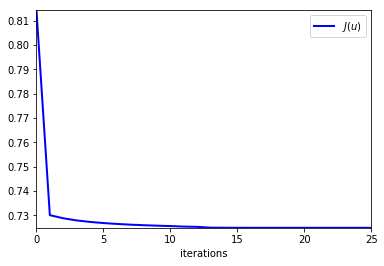

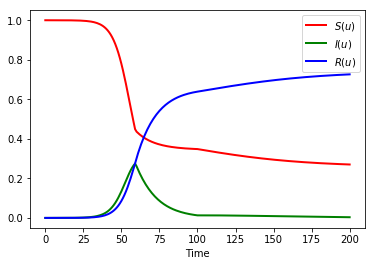

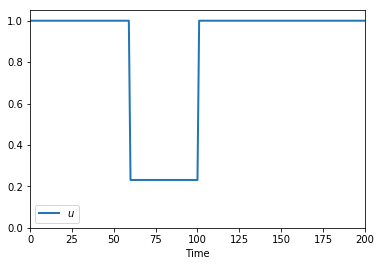

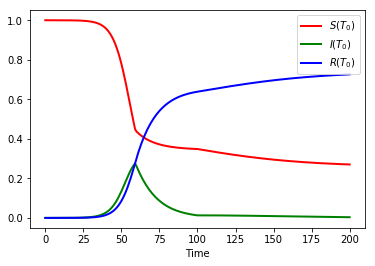

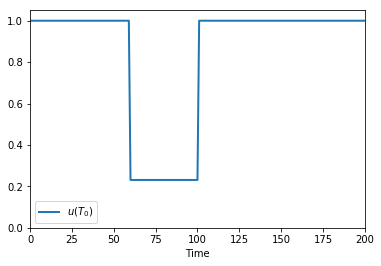

In [6]:
# minimisation with respect to u and T0 for alpha = 0.231 (figure 4)
T=100
alpha = alpha_conf
NT=int(5001) # number of time step
ITER = 5e4 # number of step in optimisation
T_end = 200.0
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
tval_end = np.linspace(t0,T_end,2*NT-1)#np.concatenate((tval,np.linspace(T,T_end,NT)),axis=0)
h = (T-t0)/(NT-1)        #the time step

# optimisation of u
u=np.ones(int(NT))
u1, i1, Jnew1, Jval1, yval1=optimSIR(u,init,True)
u_test=np.ones(int(NT))
for ind in range(int(NT/2),NT):
    u_test[ind] = alpha
u_test, i_test, Jnew_test, Jval_test, yval_test=optimSIR(u_test,init,True)
if Jval_test<Jval1:
    u1, i1, Jnew1, Jval1, yval1 = u_test, i_test, Jnew_test, Jval_test, yval_test
u_test=alpha*np.ones(int(NT))
u_test, i_test, Jnew_test, Jval_test, yval_test=optimSIR(u_test,init,True)
if Jval_test<Jval1:
    u1, i1, Jnew1, Jval1, yval1 = u_test, i_test, Jnew_test, Jval_test, yval_test
# u=1 on the last interval
u_end = np.ones(NT)
y_end = RK4_state(u_end,yval1[-1,:]) 
yval1 = np.concatenate((yval1,y_end[1:,:]),axis=0)
u1 = np.concatenate((u1,u_end[1:]),axis=0)



# optimisation of T0
u2, Jval2, yval2, T02 = optimSIR_dic_finite_dim(T,init)
#S_inf, T0, u2, Jval2, yval2, tval = exact_value_T0(T,alpha)
#u2, i2, Jnew2, Jval2, yval2, T0 =optimSIR_finite_dim(T/2,init,10000)
# u=1 on the last interval
u_end = np.ones(NT)
y_end = RK4_state(u_end,yval2[-1,:]) 
tval = np.concatenate((tval,np.linspace(T,T_end,NT)),axis=0)
yval2 = np.concatenate((yval2,y_end[1:,:]),axis=0)
u2 = np.concatenate((u2,u_end[1:]),axis=0)
T=T_end

# compute Sinf
Sinf = Dicho_S_inf(J(yval2))

# extract the values 
yval1=yval1[::50,:]
yval2=yval2[::50,:]
u1=u1[::50]
u2=u2[::50]
tval_end=tval_end[::50]


# post processing - resultats et figures
print('number of iterations in the optimisation of u:',i1)
print('J(u):',Jnew1)
#print('number of iterations in the optimisation of T0:',i2)
print('J(T0):',Jval2)
print('T0:',T02)
print('S_inf',Sinf)
plot_save_opt_sol(Jval1,yval1,u1,yval2,u2,tval_end,4)

##############################################
Iteration 1/100 and 1/4
##############################################
('T=', 1.0)


/home/duprez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


('T0=', 0.00010001000100010001)
('S_inf=', 0.06677824875404095)
##############################################
Iteration 2/100 and 1/4
##############################################
('T=', 4.020202020202021)
('T0=', 0.0004020604080610082)
('S_inf=', 0.06678351040544181)
##############################################
Iteration 3/100 and 1/4
##############################################
('T=', 7.040404040404041)
('T0=', 2.8115144847818114)
('S_inf=', 0.06678351040544181)
##############################################
Iteration 4/100 and 1/4
##############################################
('T=', 10.06060606060606)
('T0=', 5.832716604993833)
('S_inf=', 0.06678351040544181)
##############################################
Iteration 5/100 and 1/4
##############################################
('T=', 13.080808080808081)
('T0=', 8.851359883463095)
('S_inf=', 0.06678877205684267)
##############################################
Iteration 6/100 and 1/4
##############################################


('T0=', 62.195670072057716)
('S_inf=', 0.32573568409886855)
##############################################
Iteration 43/100 and 1/4
##############################################
('T=', 127.84848484848486)
('T0=', 62.20450832962085)
('S_inf=', 0.3283665097992996)
##############################################
Iteration 44/100 and 1/4
##############################################
('T=', 130.86868686868686)
('T0=', 62.20810767945481)
('S_inf=', 0.330639543204472)
##############################################
Iteration 45/100 and 1/4
##############################################
('T=', 133.88888888888889)
('T0=', 62.210998877665546)
('S_inf=', 0.33260213917699355)
##############################################
Iteration 46/100 and 1/4
##############################################
('T=', 136.9090909090909)
('T0=', 62.2040204020402)
('S_inf=', 0.33429639092807106)
##############################################
Iteration 47/100 and 1/4
##############################################
('T='

('T0=', 62.220094736746404)
('S_inf=', 0.3447881238213901)
##############################################
Iteration 84/100 and 1/4
##############################################
('T=', 251.6767676767677)
('T0=', 62.220719041601136)
('S_inf=', 0.344793385472791)
##############################################
Iteration 85/100 and 1/4
##############################################
('T=', 254.69696969696972)
('T0=', 62.22869256622633)
('S_inf=', 0.3445987043709591)
##############################################
Iteration 86/100 and 1/4
##############################################
('T=', 257.7171717171717)
('T0=', 62.21914716724197)
('S_inf=', 0.3447723388671875)
##############################################
Iteration 87/100 and 1/4
##############################################
('T=', 260.73737373737373)
('T0=', 62.21815918965633)
('S_inf=', 0.34474076895878236)
##############################################
Iteration 88/100 and 1/4
##############################################
('T=', 

('T0=', 56.4548737702053)
('S_inf=', 0.13423261971309267)
##############################################
Iteration 25/100 and 2/4
##############################################
('T=', 73.48484848484848)
('T0=', 57.206326693275386)
('S_inf=', 0.148791609139278)
##############################################
Iteration 26/100 and 2/4
##############################################
('T=', 76.5050505050505)
('T0=', 57.774741110474686)
('S_inf=', 0.16355580297009698)
##############################################
Iteration 27/100 and 2/4
##############################################
('T=', 79.52525252525253)
('T0=', 58.2024000379836)
('S_inf=', 0.17815162395608838)
##############################################
Iteration 28/100 and 2/4
##############################################
('T=', 82.54545454545455)
('T0=', 58.5223249597687)
('S_inf=', 0.19229494292160562)
##############################################
Iteration 29/100 and 2/4
##############################################
('T=', 85.

('T0=', 59.18754501712798)
('S_inf=', 0.34228357775457974)
##############################################
Iteration 66/100 and 2/4
##############################################
('T=', 197.31313131313132)
('T0=', 59.19985937987739)
('S_inf=', 0.3424729972050108)
##############################################
Iteration 67/100 and 2/4
##############################################
('T=', 200.33333333333334)
('T0=', 59.16434976831017)
('S_inf=', 0.34282026619746764)
##############################################
Iteration 68/100 and 2/4
##############################################
('T=', 203.35353535353536)
('T0=', 59.16145958030147)
('S_inf=', 0.3430202089507005)
##############################################
Iteration 69/100 and 2/4
##############################################
('T=', 206.37373737373738)
('T0=', 59.19390726951483)
('S_inf=', 0.34315175023572203)
##############################################
Iteration 70/100 and 2/4
##############################################
('T=

('T0=', 8.516675910015245)
('S_inf=', 0.06678351040544181)
##############################################
Iteration 7/100 and 3/4
##############################################
('T=', 19.12121212121212)
('T0=', 11.53506865838099)
('S_inf=', 0.06678877205684267)
##############################################
Iteration 8/100 and 3/4
##############################################
('T=', 22.141414141414142)
('T0=', 14.5550070158531)
('S_inf=', 0.06679929535964438)
##############################################
Iteration 9/100 and 3/4
##############################################
('T=', 25.161616161616163)
('T0=', 17.569597363776783)
('S_inf=', 0.06681508031384698)
##############################################
Iteration 10/100 and 3/4
##############################################
('T=', 28.181818181818183)
('T0=', 20.58042167853149)
('S_inf=', 0.06684138857085128)
##############################################
Iteration 11/100 and 3/4
##############################################
('T=',

('T0=', 35.43364033373034)
('S_inf=', 0.18767521299164874)
##############################################
Iteration 48/100 and 3/4
##############################################
('T=', 142.94949494949495)
('T0=', 34.66871939719224)
('S_inf=', 0.18861704859240305)
##############################################
Iteration 49/100 and 3/4
##############################################
('T=', 145.96969696969697)
('T0=', 33.882954962162884)
('S_inf=', 0.18944838951373924)
##############################################
Iteration 50/100 and 3/4
##############################################
('T=', 148.989898989899)
('T0=', 33.09396596225279)
('S_inf=', 0.19017975905845907)
##############################################
Iteration 51/100 and 3/4
##############################################
('T=', 152.010101010101)
('T0=', 32.32057953270074)
('S_inf=', 0.19081641887796338)
##############################################
Iteration 52/100 and 3/4
##############################################
('T='

('T0=', 4.088651289371361)
('S_inf=', 0.1951730662378772)
##############################################
Iteration 89/100 and 3/4
##############################################
('T=', 266.77777777777777)
('T0=', 3.3350557277950017)
('S_inf=', 0.1951730662378772)
##############################################
Iteration 90/100 and 3/4
##############################################
('T=', 269.7979797979798)
('T0=', 2.5633371417949875)
('S_inf=', 0.19517832788927805)
##############################################
Iteration 91/100 and 3/4
##############################################
('T=', 272.8181818181818)
('T0=', 1.8280646246442824)
('S_inf=', 0.19517832788927805)
##############################################
Iteration 92/100 and 3/4
##############################################
('T=', 275.83838383838383)
('T0=', 1.048290687654624)
('S_inf=', 0.19517832788927805)
##############################################
Iteration 93/100 and 3/4
##############################################
('T

('T0=', 44.53282095886357)
('S_inf=', 0.1112707729997306)
##############################################
Iteration 30/100 and 4/4
##############################################
('T=', 88.58585858585859)
('T0=', 43.70377441784583)
('S_inf=', 0.11430674585802802)
##############################################
Iteration 31/100 and 4/4
##############################################
('T=', 91.60606060606061)
('T0=', 42.830116344967834)
('S_inf=', 0.11701123467807112)
##############################################
Iteration 32/100 and 4/4
##############################################
('T=', 94.62626262626263)
('T0=', 41.93309027872484)
('S_inf=', 0.1194158093682651)
##############################################
Iteration 33/100 and 4/4
##############################################
('T=', 97.64646464646465)
('T0=', 41.02538233621342)
('S_inf=', 0.12152573158001079)
##############################################
Iteration 34/100 and 4/4
##############################################
('T=', 

('T0=', 6.707817246371102)
('S_inf=', 0.13412738668507543)
##############################################
Iteration 70/100 and 4/4
##############################################
('T=', 209.3939393939394)
('T0=', 5.7379677361675565)
('S_inf=', 0.13413264833647628)
##############################################
Iteration 71/100 and 4/4
##############################################
('T=', 212.41414141414143)
('T0=', 4.822283238424853)
('S_inf=', 0.13413790998787714)
##############################################
Iteration 72/100 and 4/4
##############################################
('T=', 215.43434343434345)
('T0=', 3.8566604135160993)
('S_inf=', 0.13413790998787714)
##############################################
Iteration 73/100 and 4/4
##############################################
('T=', 218.45454545454547)
('T0=', 2.9275836674576547)
('S_inf=', 0.134143171639278)
##############################################
Iteration 74/100 and 4/4
##############################################
('

('J', 1.0)
('T0', 17.90976673424918)
('S_inf', 0.06681508031384698)
##############################################
Iteration J Num 9/100 and 1/4
##############################################
('T', 25.161616161616163)
('alpha', 0.0)
('J', 1.0)
('T0', 20.92649264926493)
('S_inf', 0.06684665022225214)
##############################################
Iteration J Num 10/100 and 1/4
##############################################
('T', 28.181818181818183)
('alpha', 0.0)
('J', 1.0)
('T0', 23.942848830337578)
('S_inf', 0.06689926673626079)
##############################################
Iteration J Num 11/100 and 1/4
##############################################
('T', 31.202020202020204)
('alpha', 0.0)
('J', 0.999)
('T0', 26.9518800364885)
('S_inf', 0.06698871481007543)
##############################################
Iteration J Num 12/100 and 1/4
##############################################
('T', 34.22222222222222)
('alpha', 0.0)
('J', 0.998)
('T0', 29.961129446277962)
('S_inf', 0.067146564352

('J', 0.712)
('T0', 62.19172220252329)
('S_inf', 0.3283665097992996)
##############################################
Iteration J Num 44/100 and 1/4
##############################################
('T', 130.86868686868686)
('alpha', 0.0)
('J', 0.712)
('T0', 62.20810767945481)
('S_inf', 0.330639543204472)
##############################################
Iteration J Num 45/100 and 1/4
##############################################
('T', 133.88888888888889)
('alpha', 0.0)
('J', 0.712)
('T0', 62.19760864975387)
('S_inf', 0.33260213917699355)
##############################################
Iteration J Num 46/100 and 1/4
##############################################
('T', 136.9090909090909)
('alpha', 0.0)
('J', 0.712)
('T0', 62.2040204020402)
('S_inf', 0.33429639092807106)
##############################################
Iteration J Num 47/100 and 1/4
##############################################
('T', 139.92929292929293)
('alpha', 0.0)
('J', 0.712)
('T0', 62.20479118618932)
('S_inf', 0.3357591300

('J', 0.712)
('T0', 62.22542254225423)
('S_inf', 0.3446407975821659)
##############################################
Iteration J Num 79/100 and 1/4
##############################################
('T', 236.5757575757576)
('alpha', 0.0)
('J', 0.712)
('T0', 62.2019868653532)
('S_inf', 0.3443093135439117)
##############################################
Iteration J Num 80/100 and 1/4
##############################################
('T', 239.5959595959596)
('alpha', 0.0)
('J', 0.712)
('T0', 62.229293636434356)
('S_inf', 0.3445513495083514)
##############################################
Iteration J Num 81/100 and 1/4
##############################################
('T', 242.61616161616163)
('alpha', 0.0)
('J', 0.712)
('T0', 62.213005138897735)
('S_inf', 0.3446144893251617)
##############################################
Iteration J Num 82/100 and 1/4
##############################################
('T', 245.63636363636365)
('alpha', 0.0)
('J', 0.712)
('T0', 62.20134740746802)
('S_inf', 0.3442777436

('J', 0.998)
('T0', 32.318483363487864)
('S_inf', 0.0673517687567349)
##############################################
Iteration J Num 14/100 and 2/4
##############################################
('T', 40.26262626262626)
('alpha', 0.231)
('J', 0.996)
('T0', 35.28566796073547)
('S_inf', 0.06778848582300645)
##############################################
Iteration J Num 15/100 and 2/4
##############################################
('T', 43.282828282828284)
('alpha', 0.231)
('J', 0.993)
('T0', 38.213902198300644)
('S_inf', 0.06854090197332974)
##############################################
Iteration J Num 16/100 and 2/4
##############################################
('T', 46.303030303030305)
('alpha', 0.231)
('J', 0.988)
('T0', 41.07489536832471)
('S_inf', 0.0698247449151401)
##############################################
Iteration J Num 17/100 and 2/4
##############################################
('T', 49.323232323232325)
('alpha', 0.231)
('J', 0.98)
('T0', 43.82807472666459)
('S_inf', 0

('J', 0.712)
('T0', 59.187009610051916)
('S_inf', 0.3270090037378772)
##############################################
Iteration J Num 49/100 and 2/4
##############################################
('T', 145.96969696969697)
('alpha', 0.231)
('J', 0.712)
('T0', 59.18203335485063)
('S_inf', 0.32893476815059264)
##############################################
Iteration J Num 50/100 and 2/4
##############################################
('T', 148.989898989899)
('alpha', 0.231)
('J', 0.712)
('T0', 59.16980586947584)
('S_inf', 0.3306448048558729)
##############################################
Iteration J Num 51/100 and 2/4
##############################################
('T', 152.010101010101)
('alpha', 0.231)
('J', 0.712)
('T0', 59.18345066829915)
('S_inf', 0.3321864687163255)
##############################################
Iteration J Num 52/100 and 2/4
##############################################
('T', 155.03030303030303)
('alpha', 0.231)
('J', 0.712)
('T0', 59.18098476514319)
('S_inf', 0.333

('J', 0.712)
('T0', 59.161313101007075)
('S_inf', 0.3443303601495151)
##############################################
Iteration J Num 84/100 and 2/4
##############################################
('T', 251.6767676767677)
('alpha', 0.231)
('J', 0.712)
('T0', 59.175125593367426)
('S_inf', 0.3445513495083514)
##############################################
Iteration J Num 85/100 and 2/4
##############################################
('T', 254.69696969696972)
('alpha', 0.231)
('J', 0.712)
('T0', 59.17202326293236)
('S_inf', 0.34456187281115314)
##############################################
Iteration J Num 86/100 and 2/4
##############################################
('T', 257.7171717171717)
('alpha', 0.231)
('J', 0.712)
('T0', 59.17778040430306)
('S_inf', 0.3445987043709591)
##############################################
Iteration J Num 87/100 and 2/4
##############################################
('T', 260.73737373737373)
('alpha', 0.231)
('J', 0.712)
('T0', 59.16722682369247)
('S_inf', 0.

('J', 0.98)
('T0', 43.18765209854319)
('S_inf', 0.07171893941945043)
##############################################
Iteration J Num 19/100 and 3/4
##############################################
('T', 55.36363636363637)
('alpha', 0.7)
('J', 0.97)
('T0', 45.28090990917274)
('S_inf', 0.07452866126751076)
##############################################
Iteration J Num 20/100 and 3/4
##############################################
('T', 58.38383838383839)
('alpha', 0.7)
('J', 0.956)
('T0', 46.997851300281546)
('S_inf', 0.0783538818359375)
##############################################
Iteration J Num 21/100 and 3/4
##############################################
('T', 61.40404040404041)
('alpha', 0.7)
('J', 0.941)
('T0', 48.31138972483107)
('S_inf', 0.08317355451912717)
##############################################
Iteration J Num 22/100 and 3/4
##############################################
('T', 64.42424242424244)
('alpha', 0.7)
('J', 0.924)
('T0', 49.23148678504215)
('S_inf', 0.08883509142

('J', 0.761)
('T0', 30.74389762208544)
('S_inf', 0.19187401080953667)
##############################################
Iteration J Num 54/100 and 3/4
##############################################
('T', 161.07070707070707)
('alpha', 0.7)
('J', 0.761)
('T0', 29.978256411499736)
('S_inf', 0.19230546622440736)
##############################################
Iteration J Num 55/100 and 3/4
##############################################
('T', 164.0909090909091)
('alpha', 0.7)
('J', 0.761)
('T0', 29.194692196492376)
('S_inf', 0.19267904347386855)
##############################################
Iteration J Num 56/100 and 3/4
##############################################
('T', 167.11111111111111)
('alpha', 0.7)
('J', 0.76)
('T0', 28.41173006189508)
('S_inf', 0.193005265860722)
##############################################
Iteration J Num 57/100 and 3/4
##############################################
('T', 170.13131313131314)
('alpha', 0.7)
('J', 0.76)
('T0', 27.6491032941678)
('S_inf', 0.193294656

('J', 0.759)
('T0', 4.062272893956062)
('S_inf', 0.1951730662378772)
##############################################
Iteration J Num 89/100 and 3/4
##############################################
('T', 266.77777777777777)
('alpha', 0.7)
('J', 0.759)
('T0', 3.3083752819726415)
('S_inf', 0.1951730662378772)
##############################################
Iteration J Num 90/100 and 3/4
##############################################
('T', 269.7979797979798)
('alpha', 0.7)
('J', 0.759)
('T0', 2.5363546455655666)
('S_inf', 0.19517832788927805)
##############################################
Iteration J Num 91/100 and 3/4
##############################################
('T', 272.8181818181818)
('alpha', 0.7)
('J', 0.759)
('T0', 1.8007800780078007)
('S_inf', 0.19517832788927805)
##############################################
Iteration J Num 92/100 and 3/4
##############################################
('T', 275.83838383838383)
('alpha', 0.7)
('J', 0.759)
('T0', 1.0207040906110811)
('S_inf', 0.19517

('J', 0.928)
('T0', 47.19559733751152)
('S_inf', 0.08719345618938579)
##############################################
Iteration J Num 24/100 and 4/4
##############################################
('T', 70.46464646464646)
('alpha', 0.8)
('J', 0.916)
('T0', 47.201940396059804)
('S_inf', 0.0916290283203125)
##############################################
Iteration J Num 25/100 and 4/4
##############################################
('T', 73.48484848484848)
('alpha', 0.8)
('J', 0.904)
('T0', 46.96151433325151)
('S_inf', 0.09602250724003233)
##############################################
Iteration J Num 26/100 and 4/4
##############################################
('T', 76.5050505050505)
('alpha', 0.8)
('J', 0.893)
('T0', 46.52737394951616)
('S_inf', 0.10024761331492457)
##############################################
Iteration J Num 27/100 and 4/4
##############################################
('T', 79.52525252525253)
('alpha', 0.8)
('J', 0.884)
('T0', 45.962239658309265)
('S_inf', 0.104230683

('J', 0.827)
('T0', 17.091763721826727)
('S_inf', 0.13398532209725214)
##############################################
Iteration J Num 59/100 and 4/4
##############################################
('T', 176.17171717171718)
('alpha', 0.8)
('J', 0.827)
('T0', 16.15656212085855)
('S_inf', 0.13401689200565733)
##############################################
Iteration J Num 60/100 and 4/4
##############################################
('T', 179.1919191919192)
('alpha', 0.8)
('J', 0.827)
('T0', 15.214915430937031)
('S_inf', 0.13403793861126076)
##############################################
Iteration J Num 61/100 and 4/4
##############################################
('T', 182.21212121212122)
('alpha', 0.8)
('J', 0.827)
('T0', 14.268635954504543)
('S_inf', 0.13405372356546338)
##############################################
Iteration J Num 62/100 and 4/4
##############################################
('T', 185.23232323232324)
('alpha', 0.8)
('J', 0.827)
('T0', 13.319535994003441)
('S_inf', 0.13

('J', 0.827)
('T0', 0.027888647450603647)
('S_inf', 0.1341536949420797)
##############################################
Iteration J Num 94/100 and 4/4
##############################################
('T', 281.8787878787879)
('alpha', 0.8)
('J', 0.827)
('T0', 0.028190697857664555)
('S_inf', 0.1341536949420797)
##############################################
Iteration J Num 95/100 and 4/4
##############################################
('T', 284.8989898989899)
('alpha', 0.8)
('J', 0.827)
('T0', 0.028492748264725462)
('S_inf', 0.1341536949420797)
##############################################
Iteration J Num 96/100 and 4/4
##############################################
('T', 287.9191919191919)
('alpha', 0.8)
('J', 0.827)
('T0', 0.02879479867178637)
('S_inf', 0.1341536949420797)
##############################################
Iteration J Num 97/100 and 4/4
##############################################
('T', 290.93939393939394)
('alpha', 0.8)
('J', 0.827)
('T0', 0.029096849078847277)
('S_inf', 

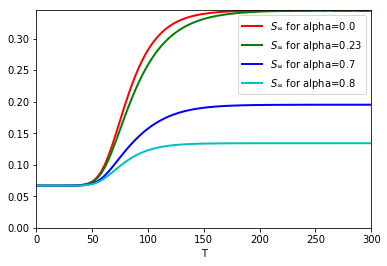

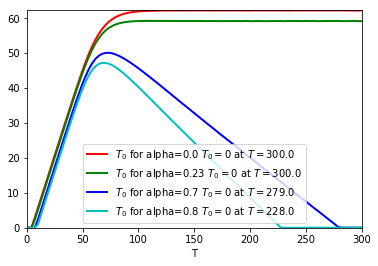

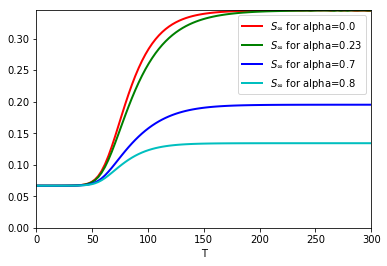

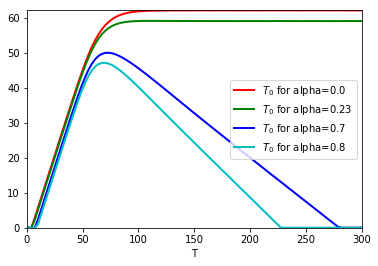

In [4]:
#graphique S infini et T0 en fonction de T (figure 5-6) 

# parameters
min_T=1
max_T=300
nb_T = 100
Time = np.linspace(min_T,max_T,nb_T)
alpha_array=[0.0,alpha_conf,0.7,0.8]
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','yellow']

# Computation of T0 Sinf theoretical
NT=int(10000) # number of time step
S_inf_theo_array =  np.zeros((len(Time),len(alpha_array)))
T0_theo_array =  np.zeros((len(Time),len(alpha_array)))
min_zero =  np.zeros(len(alpha_array))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_T in range(len(Time)):
        T = Time[ind_T]
        print('##############################################')
        print('Iteration '+str(ind_T+1)+'/'+str(len(Time))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array)))
        print('##############################################')
        print("T=",T)
        tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
        h = (T-t0)/(NT-1)        #the time step
        S_inf, T0, u, Jval, yval, tval =  exact_value_T0(T,alpha)
        #T0init = T/2
        #u, Jval, yval, T0 = optimSIR_dic_finite_dim(T,init)
        #u, i, Jnew, Jval, yval, T0 =  optimSIR_finite_dim(T0init,init)
        print('T0=',T0)
        print('S_inf=',S_inf)
        S_inf_theo_array[ind_T,ind_alpha] = S_inf
        T0_theo_array[ind_T,ind_alpha] = T0
    ind_T = nb_T-1
    min_zero[ind_alpha] = max_T
    while T0_theo_array[ind_T,ind_alpha]<=1 and ind_T>=0:
        min_zero[ind_alpha] = Time[ind_T]
        ind_T=ind_T-1

        
# Computation of T0 Sinf theoretical by optimisation
NT=int(10000) # number of time step
T0_opt_array =  np.zeros((len(Time),len(alpha_array)))
S_inf_opt_array =  np.zeros((len(Time),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_T in range(len(Time)):
        print('##############################################')
        print('Iteration J Num '+str(ind_T+1)+'/'+str(len(Time))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array)))
        print('##############################################')
        T = Time[ind_T]
        print('T',T)
        print('alpha',alpha)
        tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
        h = (T-t0)/(NT-1)        #the time step
        u, Jval, yval, T0 = optimSIR_dic_finite_dim(T,init)
        S_inf = Dicho_S_inf(J(yval))
        T0_opt_array[ind_T,ind_alpha] = T0
        S_inf_opt_array[ind_T,ind_alpha] = S_inf
        print('J',np.round(Jval,3))
        print('T0',T0)
        print('S_inf',S_inf)
        plt.show()

# post processing - resultats et figures
# Plot
plt.figure(1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(Time,S_inf_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel('T')
plt.axis([0, max(Time),0.0, np.max(S_inf_theo_array)])
plt.savefig("fig5_simu_covid_S_infinity_with_respect_to_T_theo.png")
plt.figure(2)
for ind_alpha in range(len(alpha_array)):
    plt.plot(Time,T0_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$T_0$ for alpha={0} $T_0=0$ at $T=${1}'.format(round(alpha_array[ind_alpha],2),round(min_zero[ind_alpha],0)))
plt.legend(loc='best')
plt.xlabel('T')
plt.axis([0, max(Time), 0.0, np.max(T0_theo_array)])
plt.savefig("fig6_simu_covid_T0_with_respect_to_T_theo.png")
plt.figure(3)
for ind_alpha in range(len(alpha_array)):
    plt.plot(Time,S_inf_opt_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel('T')
plt.axis([0, max(Time),0.0, np.max(S_inf_opt_array)])
plt.savefig("fig5_simu_covid_S_infinity_with_respect_to_T_opt.png")
plt.figure(4)
for ind_alpha in range(len(alpha_array)):
    plt.plot(Time,T0_opt_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$T_0$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel('T')
plt.axis([0, max(Time), 0.0, np.max(T0_opt_array)])
plt.savefig("fig6_simu_covid_T0_with_respect_to_T_opt.png")
plt.show()


# Save the values for tikz
File = open('fig5_simu_covid_S_infinity_with_respect_to_T.txt','w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0},opacity = 0.25,line width=1mm]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,Time,S_inf_opt_array[:,ind_alpha])
    File.write(' };\n\n')
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,Time,S_inf_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
File = open('fig6_simu_covid_T0_with_respect_to_T.txt','w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0},opacity = 0.25,line width=1mm]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,Time,T0_opt_array[:,ind_alpha])
    File.write(' };\n\n')
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,Time,T0_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()







##############################################
Iteration T: 1/3 and alpha: 1/100
##############################################
('T=', 100)


/home/duprez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


('T0=', 61.93619361936194)
('S_inf=', 0.28217973380253236)
##############################################
Iteration T: 2/3 and alpha: 1/100
##############################################
('T=', 200)
('T0=', 62.20622062206221)
('S_inf=', 0.3442619586813038)
##############################################
Iteration T: 3/3 and alpha: 1/100
##############################################
('T=', 400)
('T0=', 62.20622062206221)
('S_inf=', 0.34419881886449355)
##############################################
Iteration T: 1/3 and alpha: 2/100
##############################################
('T=', 100)
('T0=', 61.85618561856186)
('S_inf=', 0.28133786957839435)
##############################################
Iteration T: 2/3 and alpha: 2/100
##############################################
('T=', 200)
('T0=', 62.14621462146215)
('S_inf=', 0.3438568115234375)
##############################################
Iteration T: 3/3 and alpha: 2/100
##############################################
('T=', 400)
('T0=',

('T0=', 60.42604260426043)
('S_inf=', 0.2690887451171875)
##############################################
Iteration T: 2/3 and alpha: 15/100
##############################################
('T=', 200)
('T0=', 60.586058605860586)
('S_inf=', 0.3437094852842134)
##############################################
Iteration T: 3/3 and alpha: 15/100
##############################################
('T=', 400)
('T0=', 60.64606460646065)
('S_inf=', 0.3433464313375539)
##############################################
Iteration T: 1/3 and alpha: 16/100
##############################################
('T=', 100)
('T0=', 60.296029602960296)
('S_inf=', 0.2680364148370151)
##############################################
Iteration T: 2/3 and alpha: 16/100
##############################################
('T=', 200)
('T0=', 60.46604660466047)
('S_inf=', 0.34349901922817894)
##############################################
Iteration T: 3/3 and alpha: 16/100
##############################################
('T=', 400)
('

('T0=', 58.425842584258426)
('S_inf=', 0.25241983347925645)
##############################################
Iteration T: 2/3 and alpha: 29/100
##############################################
('T=', 200)
('T0=', 58.24582458245825)
('S_inf=', 0.3420257568359376)
##############################################
Iteration T: 3/3 and alpha: 29/100
##############################################
('T=', 400)
('T0=', 58.28582858285829)
('S_inf=', 0.34376736344962283)
##############################################
Iteration T: 1/3 and alpha: 30/100
##############################################
('T=', 100)
('T0=', 58.24582458245825)
('S_inf=', 0.25105180411503236)
##############################################
Iteration T: 2/3 and alpha: 30/100
##############################################
('T=', 200)
('T0=', 58.04580458045805)
('S_inf=', 0.3417942441742996)
##############################################
Iteration T: 3/3 and alpha: 30/100
##############################################
('T=', 400)
(

('T0=', 55.65556555655566)
('S_inf=', 0.23037877576104523)
##############################################
Iteration T: 2/3 and alpha: 43/100
##############################################
('T=', 200)
('T0=', 54.245424542454245)
('S_inf=', 0.33740602690598065)
##############################################
Iteration T: 3/3 and alpha: 43/100
##############################################
('T=', 400)
('T0=', 54.28542854285429)
('S_inf=', 0.34396730620285565)
##############################################
Iteration T: 1/3 and alpha: 44/100
##############################################
('T=', 100)
('T0=', 55.41554155415542)
('S_inf=', 0.2285266744679418)
##############################################
Iteration T: 2/3 and alpha: 44/100
##############################################
('T=', 200)
('T0=', 53.84538453845385)
('S_inf=', 0.3368272452518858)
##############################################
Iteration T: 3/3 and alpha: 44/100
##############################################
('T=', 400)
(

('T0=', 51.605160516051605)
('S_inf=', 0.19981910442483838)
##############################################
Iteration T: 2/3 and alpha: 57/100
##############################################
('T=', 200)
('T0=', 40.94409440944094)
('S_inf=', 0.31490194386449355)
##############################################
Iteration T: 3/3 and alpha: 57/100
##############################################
('T=', 400)
('T0=', 24.802480248024803)
('S_inf=', 0.34397782950565736)
##############################################
Iteration T: 1/3 and alpha: 58/100
##############################################
('T=', 100)
('T0=', 51.24512451245125)
('S_inf=', 0.1971988020272091)
##############################################
Iteration T: 2/3 and alpha: 58/100
##############################################
('T=', 200)
('T0=', 38.703870387038705)
('S_inf=', 0.30887735301050645)
##############################################
Iteration T: 3/3 and alpha: 58/100
##############################################
('T=', 400

('T0=', 0.040004000400040006)
('S_inf=', 0.20290769379714443)
##############################################
Iteration T: 1/3 and alpha: 71/100
##############################################
('T=', 100)
('T0=', 45.654565456545654)
('S_inf=', 0.15743124073949352)
##############################################
Iteration T: 2/3 and alpha: 71/100
##############################################
('T=', 200)
('T0=', 20.102010201020104)
('S_inf=', 0.1947258258688039)
##############################################
Iteration T: 3/3 and alpha: 71/100
##############################################
('T=', 400)
('T0=', 0.040004000400040006)
('S_inf=', 0.19518885119207977)
##############################################
Iteration T: 1/3 and alpha: 72/100
##############################################
('T=', 100)
('T0=', 45.16451645164517)
('S_inf=', 0.1540216906317349)
##############################################
Iteration T: 2/3 and alpha: 72/100
##############################################
('T=',

('T0=', 5.180518051805181)
('S_inf=', 0.12033659836341595)
##############################################
Iteration T: 3/3 and alpha: 84/100
##############################################
('T=', 400)
('T0=', 0.040004000400040006)
('S_inf=', 0.12035238331761852)
##############################################
Iteration T: 1/3 and alpha: 85/100
##############################################
('T=', 100)
('T0=', 37.82378237823782)
('S_inf=', 0.10979224895608836)
##############################################
Iteration T: 2/3 and alpha: 85/100
##############################################
('T=', 200)
('T0=', 4.000400040004001)
('S_inf=', 0.11610623063712286)
##############################################
Iteration T: 3/3 and alpha: 85/100
##############################################
('T=', 400)
('T0=', 0.040004000400040006)
('S_inf=', 0.11611675393992457)
##############################################
Iteration T: 1/3 and alpha: 86/100
##############################################
('T=',

('T0=', 24.822482248224823)
('S_inf=', 0.07352894750134698)
##############################################
Iteration T: 2/3 and alpha: 98/100
##############################################
('T=', 200)
('T0=', 0.020002000200020003)
('S_inf=', 0.07389200144800648)
##############################################
Iteration T: 3/3 and alpha: 98/100
##############################################
('T=', 400)
('T0=', 0.040004000400040006)
('S_inf=', 0.07389200144800648)
##############################################
Iteration T: 1/3 and alpha: 99/100
##############################################
('T=', 100)
('T0=', 22.332233223322334)
('S_inf=', 0.07121382088496767)
##############################################
Iteration T: 2/3 and alpha: 99/100
##############################################
('T=', 200)
('T0=', 0.020002000200020003)
('S_inf=', 0.07143481024380388)
##############################################
Iteration T: 3/3 and alpha: 99/100
##############################################
(

('J', 0.712)
##############################################
Iteration J Num 1/3 and 17/100
##############################################
('J', 0.722)
##############################################
Iteration J Num 2/3 and 17/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 3/3 and 17/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 1/3 and 18/100
##############################################
('J', 0.723)
##############################################
Iteration J Num 2/3 and 18/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 3/3 and 18/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 1/3 and 19/100
##############################################
('J', 0.723)
#####################

('J', 0.712)
##############################################
Iteration J Num 1/3 and 37/100
##############################################
('J', 0.732)
##############################################
Iteration J Num 2/3 and 37/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 3/3 and 37/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 1/3 and 38/100
##############################################
('J', 0.733)
##############################################
Iteration J Num 2/3 and 38/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 3/3 and 38/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 1/3 and 39/100
##############################################
('J', 0.733)
#####################

('J', 0.712)
##############################################
Iteration J Num 1/3 and 57/100
##############################################
('J', 0.755)
##############################################
Iteration J Num 2/3 and 57/100
##############################################
('J', 0.713)
##############################################
Iteration J Num 3/3 and 57/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 1/3 and 58/100
##############################################
('J', 0.757)
##############################################
Iteration J Num 2/3 and 58/100
##############################################
('J', 0.714)
##############################################
Iteration J Num 3/3 and 58/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 1/3 and 59/100
##############################################
('J', 0.759)
#####################

('J', 0.79)
##############################################
Iteration J Num 1/3 and 77/100
##############################################
('J', 0.823)
##############################################
Iteration J Num 2/3 and 77/100
##############################################
('J', 0.797)
##############################################
Iteration J Num 3/3 and 77/100
##############################################
('J', 0.797)
##############################################
Iteration J Num 1/3 and 78/100
##############################################
('J', 0.828)
##############################################
Iteration J Num 2/3 and 78/100
##############################################
('J', 0.805)
##############################################
Iteration J Num 3/3 and 78/100
##############################################
('J', 0.804)
##############################################
Iteration J Num 1/3 and 79/100
##############################################
('J', 0.834)
######################

('J', 0.954)
##############################################
Iteration J Num 1/3 and 97/100
##############################################
('J', 0.965)
##############################################
Iteration J Num 2/3 and 97/100
##############################################
('J', 0.963)
##############################################
Iteration J Num 3/3 and 97/100
##############################################
('J', 0.963)
##############################################
Iteration J Num 1/3 and 98/100
##############################################
('J', 0.974)
##############################################
Iteration J Num 2/3 and 98/100
##############################################
('J', 0.972)
##############################################
Iteration J Num 3/3 and 98/100
##############################################
('J', 0.972)
##############################################
Iteration J Num 1/3 and 99/100
##############################################
('J', 0.982)
#####################

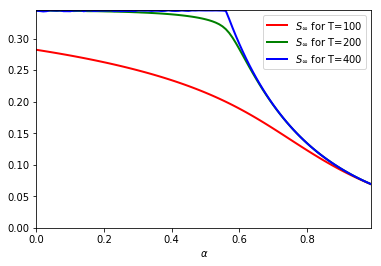

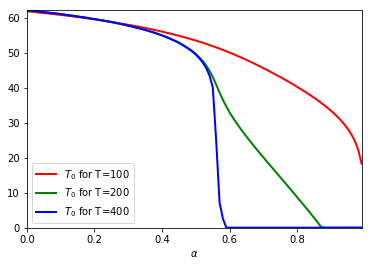

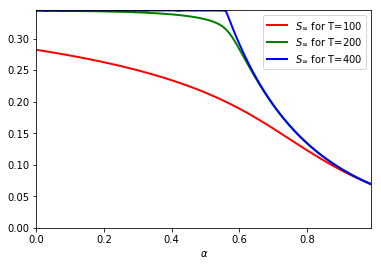

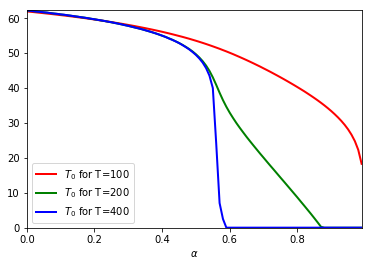

In [5]:
#graphique S infini et T0 en fonction de alpha (figure 5-6)

# parameters
nb_alpha = 100
min_alpha = 0.0
max_alpha = 0.99
alpha_array = np.linspace(min_alpha,max_alpha,nb_alpha)
Time=[100,200,400]
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','yellow']


NT=int(10000) # number of time step
S_inf_theo_array =  np.zeros((len(alpha_array),len(Time)))
T0_theo_array =  np.zeros((len(alpha_array),len(Time)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_T in range(len(Time)):
        T = Time[ind_T]
        print('##############################################')
        print('Iteration T: '+str(ind_T+1)+'/'+str(len(Time))+' and alpha: '+str(ind_alpha+1)+'/'+str(len(alpha_array)))
        print('##############################################')
        print("T=",T)
        tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
        h = (T-t0)/(NT-1)        #the time step
        S_inf, T0, u, Jval, yval, tval =  exact_value_T0(T,alpha)
        #T0init = T/2
        #u, Jval, yval, T0 = optimSIR_dic_finite_dim(T,init)
        #u, i, Jnew, Jval, yval, T0 =  optimSIR_finite_dim(T0init,init)
        print('T0=',T0)
        S_inf = Dicho_S_inf(J(yval))
        print('S_inf=',S_inf)
        S_inf_theo_array[ind_alpha,ind_T] = S_inf
        T0_theo_array[ind_alpha,ind_T] = T0

# Computation of the numerical value of J optimal
NT=int(10000) # number of time step
T0_opt_array =  np.zeros((len(alpha_array),len(Time)))
S_inf_opt_array =   np.zeros((len(alpha_array),len(Time)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_T in range(len(Time)):
        print('##############################################')
        print('Iteration J Num '+str(ind_T+1)+'/'+str(len(Time))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array)))
        print('##############################################')
        T = Time[ind_T]
        tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
        h = (T-t0)/(NT-1)        #the time step
        u, Jval, yval, T0 = optimSIR_dic_finite_dim(T,init)
        S_inf = Dicho_S_inf(J(yval))
        T0_opt_array[ind_alpha,ind_T] = T0
        S_inf_opt_array[ind_alpha,ind_T] = S_inf
        print('J',np.round(Jval,3))



# post processing - resultats et figures
# Plot
plt.figure(1)
for ind_T in range(len(Time)):
    plt.plot(alpha_array,S_inf_theo_array[:,ind_T],'{0}'.format(color_plt[ind_T]),linewidth=2,label=r'$S_\infty$ for T={0}'.format(Time[ind_T]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array),0.0, np.max(S_inf_theo_array)])
plt.savefig("fig5_simu_covid_S_infinity_with_respect_to_alpha_theo.png")
plt.figure(2)
for ind_T in range(len(Time)):
    plt.plot(alpha_array,T0_theo_array[:,ind_T],'{0}'.format(color_plt[ind_T]),linewidth=2,label=r'$T_0$ for T={0}'.format(Time[ind_T]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array), 0.0, np.max(T0_theo_array)])
plt.savefig("fig6_simu_covid_T0_with_respect_to_alpha_theo.png")
plt.figure(3)
for ind_T in range(len(Time)):
    plt.plot(alpha_array,S_inf_opt_array[:,ind_T],'{0}'.format(color_plt[ind_T]),linewidth=2,label=r'$S_\infty$ for T={0}'.format(Time[ind_T]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array),0.0, np.max(S_inf_opt_array)])
plt.savefig("fig5_simu_covid_S_infinity_with_respect_to_alpha_opt.png")
plt.figure(4)
for ind_T in range(len(Time)):
    plt.plot(alpha_array,T0_opt_array[:,ind_T],'{0}'.format(color_plt[ind_T]),linewidth=2,label=r'$T_0$ for T={0}'.format(Time[ind_T]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array), 0.0, np.max(T0_opt_array)])
plt.savefig("fig6_simu_covid_T0_with_respect_to_alpha_opt.png")
plt.show()

# Save the values for tikz
File = open('fig5_simu_covid_S_infinity_with_respect_to_alpha.txt','w')
for ind_T in range(len(Time)):
    File.write('\\addplot[color={0},opacity = 0.25,line width=1mm]'.format(color_tikz[ind_T]))
    File.write(' coordinates { ')
    write_to_file(File,alpha_array,S_inf_opt_array[:,ind_T])
    File.write(' };\n\n')
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_T]))
    File.write(' coordinates { ')
    write_to_file(File,alpha_array,S_inf_theo_array[:,ind_T])
    File.write(' };\n\n')
File.close()
File = open('fig6_simu_covid_T0_with_respect_to_alpha.txt','w')
for ind_T in range(len(Time)):
    File.write('\\addplot[color={0},opacity = 0.25,line width=1mm]'.format(color_tikz[ind_T]))
    File.write(' coordinates { ')
    write_to_file(File,alpha_array,T0_opt_array[:,ind_T])
    File.write(' };\n\n')
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_T]))
    File.write(' coordinates { ')
    write_to_file(File,alpha_array,T0_theo_array[:,ind_T])
    File.write(' };\n\n')
File.close()




Argmin de J pour T=200: [62.626 60.606 56.566 34.343 10.101  0.   ]
Argmin de J pour T=300: [63.636 60.606 57.576 15.152  0.     0.   ]


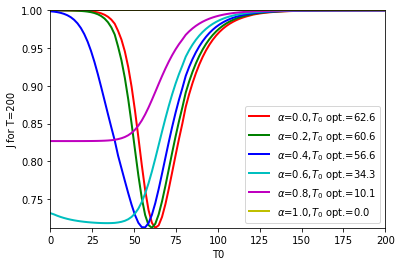

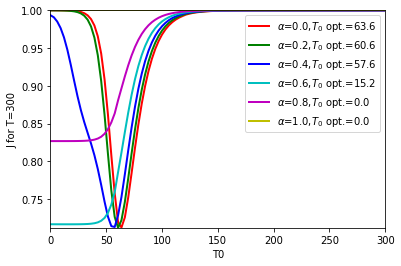

In [6]:
# calcul de J pour toute les valeurs de T0 (figure 7)

# parameters
NT=int(5e2) # number of time step
ITER = 5e4 # number of step in optimisation
alpha_array = np.linspace(0,1,6)
color=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','yellow','brown','black']

T=200
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)  
T0_array = np.linspace(0,T,100)
Jval_array = np.zeros((len(T0_array),len(alpha_array)))
argmin_J = np.zeros(len(alpha_array))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind in range(len(T0_array)):
        T0 = T0_array[ind]
        u=np.ones(int(NT))
        for ii in range(int(T0*NT/T)-1,int(NT)):
            u[ii]=alpha
        yval=RK4_state(u,init)
        Jval=J(yval)
        #print(Jval)
        Jval_array[ind,ind_alpha] = Jval
    ind_min = np.argmin(Jval_array[:,ind_alpha])
    argmin_J[ind_alpha] = T0_array[ind_min]
    

# Plot
plt.figure(1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(T0_array,Jval_array[:,ind_alpha],'{0}'.format(color[ind_alpha]),linewidth=2,label=r'$\alpha$={0},$T_0$ opt.={1}'.format(alpha_array[ind_alpha],round(argmin_J[ind_alpha],1)))
plt.legend(loc='best')
plt.xlabel('T0')
plt.ylabel('J for T={0}'.format(T))
plt.axis([0,T,np.min(Jval_array),np.max(Jval_array)])
plt.savefig("fig7_simu_covid_values_J_T_{0}.png".format(T))

# Save the values for tikz
File = open('fig7_simu_covid_values_J_T_{0}.txt'.format(T),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,T0_array,Jval_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()

print('Argmin de J pour T={0}: '.format(T)+str(np.round(argmin_J,3)))

T=300
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)  
T0_array = np.linspace(0,T,100)
Jval_array = np.zeros((len(T0_array),len(alpha_array)))
argmin_J = np.zeros(len(alpha_array))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind in range(len(T0_array)):
        T0 = T0_array[ind]
        u=np.ones(int(NT))
        for ii in range(int(T0*NT/T)-1,int(NT)):
            u[ii]=alpha
        yval=RK4_state(u,init)
        Jval=J(yval)
        #print(Jval)
        Jval_array[ind,ind_alpha] = Jval
    ind_min = np.argmin(Jval_array[:,ind_alpha])
    argmin_J[ind_alpha] = T0_array[ind_min]


# Plot
plt.figure(2)
for ind_alpha in range(len(alpha_array)):
    plt.plot(T0_array,Jval_array[:,ind_alpha],'{0}'.format(color[ind_alpha]),linewidth=2,label=r'$\alpha$={0},$T_0$ opt.={1}'.format(alpha_array[ind_alpha],round(argmin_J[ind_alpha],1)))
plt.legend(loc='best')
plt.xlabel('T0')
plt.ylabel('J for T={0}'.format(T))
plt.axis([0,T,np.min(Jval_array),np.max(Jval_array)])
plt.savefig("fig7_simu_covid_values_J_T_{0}.png".format(T))


# Save the values for tikz
File = open('fig7_simu_covid_values_J_T_{0}.txt'.format(T),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,T0_array,Jval_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
print('Argmin de J pour T={0}: '.format(T)+str(np.round(argmin_J,3)))

plt.show()


